In [19]:
import pandas as pd
import IPython
from IPython.display import display, SVG, clear_output, HTML
from ipywidgets import widgets
import time
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
import sqlite3
import seaborn as sns
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import plotly.graph_objs as go

In [2]:
con = sqlite3.connect('prices.db')

In [3]:
stocks = pd.read_sql("SELECT * FROM stocks;", con)

In [4]:
stocks

,id,stock_symbol,price,timestamp
0,1,AAPL,190.90,2024-05-22 13:26:06
1,2,GOOGL,176.38,2024-05-22 13:26:06
2,3,TSLA,180.11,2024-05-22 13:26:06
3,4,AAPL,190.90,2024-05-22 19:16:17
4,5,GOOGL,176.38,2024-05-22 19:16:17
...,...,...,...,...
118,119,NVDA,1224.40,2024-06-05 19:36:14
119,120,AAPL,195.87,2024-06-05 20:27:27
120,121,GOOGL,175.41,2024-06-05 20:27:27
121,122,TSLA,175.00,2024-06-05 20:27:27


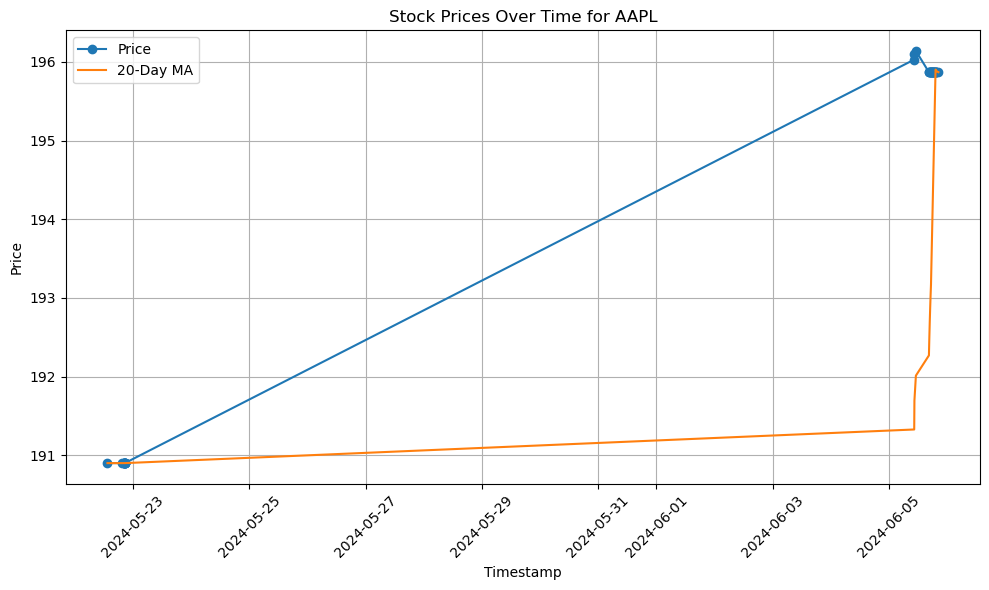

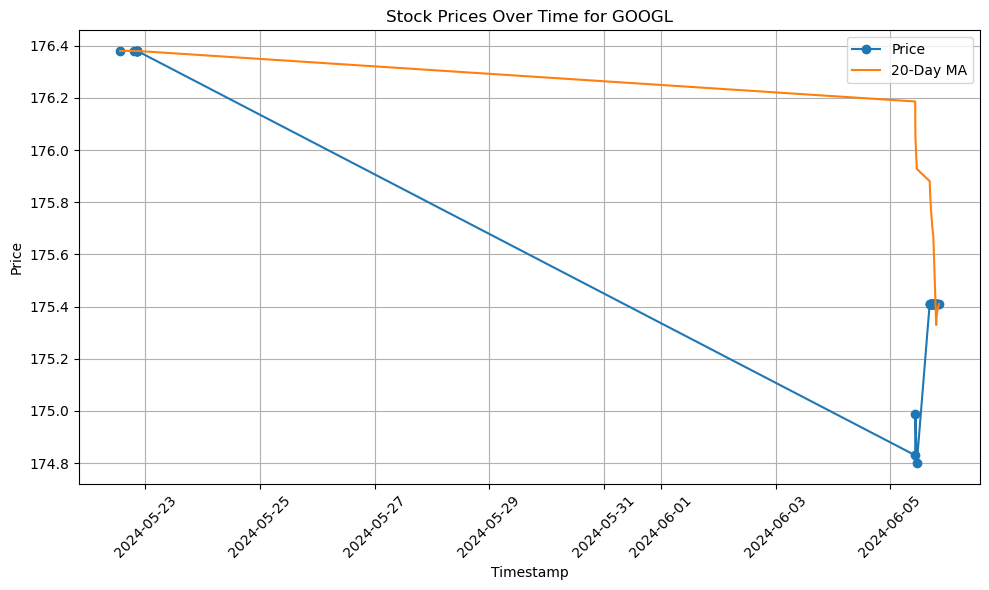

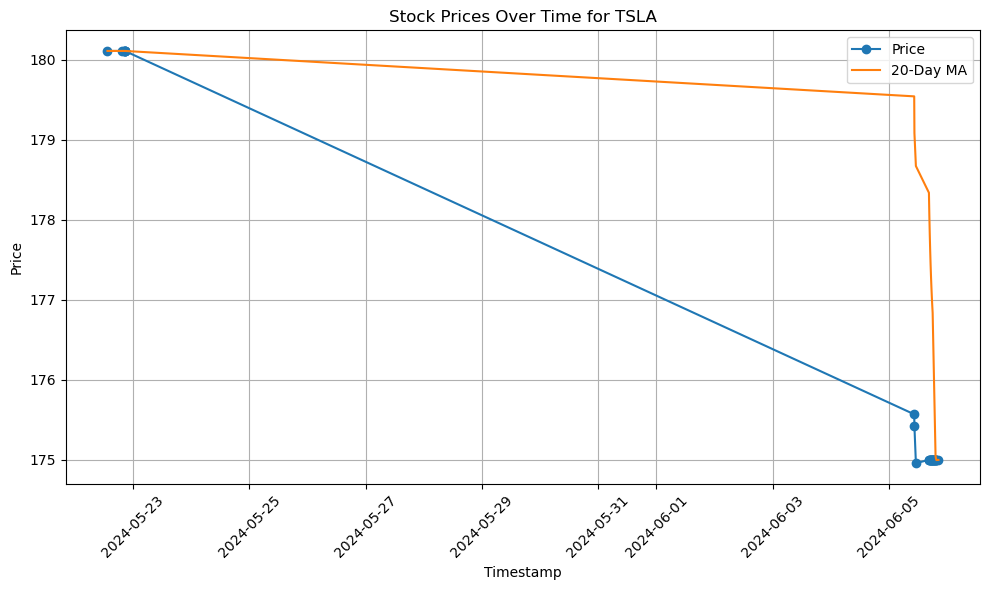

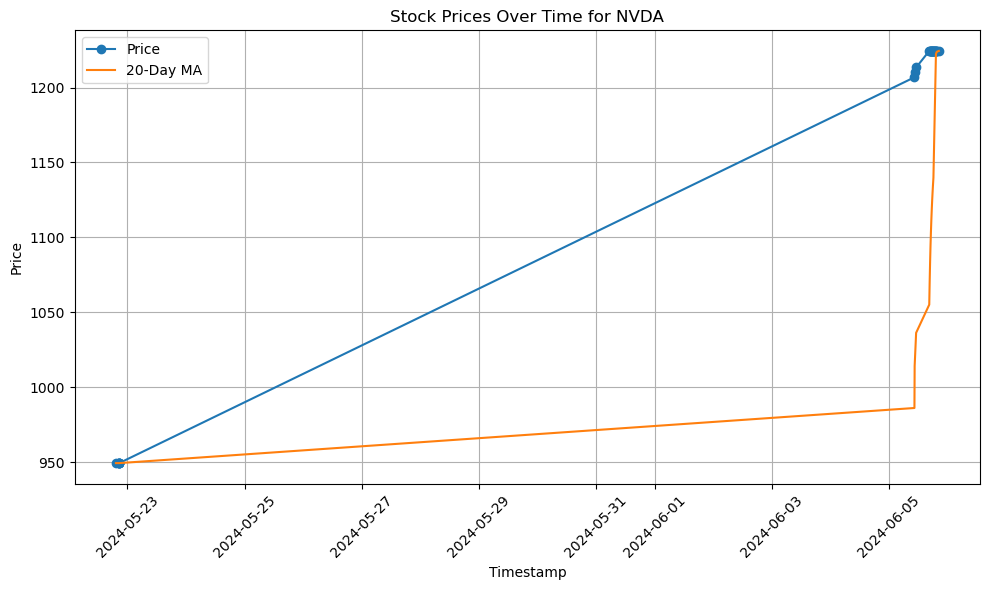

In [21]:
# Calculate moving averages
stocks['20_MA'] = stocks.groupby('stock_symbol')['price'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())

# Plot each stock separately with moving averages
stock_symbols = stocks['stock_symbol'].unique()

for stock_symbol in stock_symbols:
    stock_data = stocks[stocks['stock_symbol'] == stock_symbol]
    plt.figure(figsize=(10, 6))
    plt.plot(stock_data['timestamp'], stock_data['price'], marker='o', linestyle='-', label='Price')
    plt.plot(stock_data['timestamp'], stock_data['20_MA'], marker='', linestyle='-', label='20-Day MA')
    plt.xlabel('Timestamp')
    plt.ylabel('Price')
    plt.title(f'Stock Prices Over Time for {stock_symbol}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

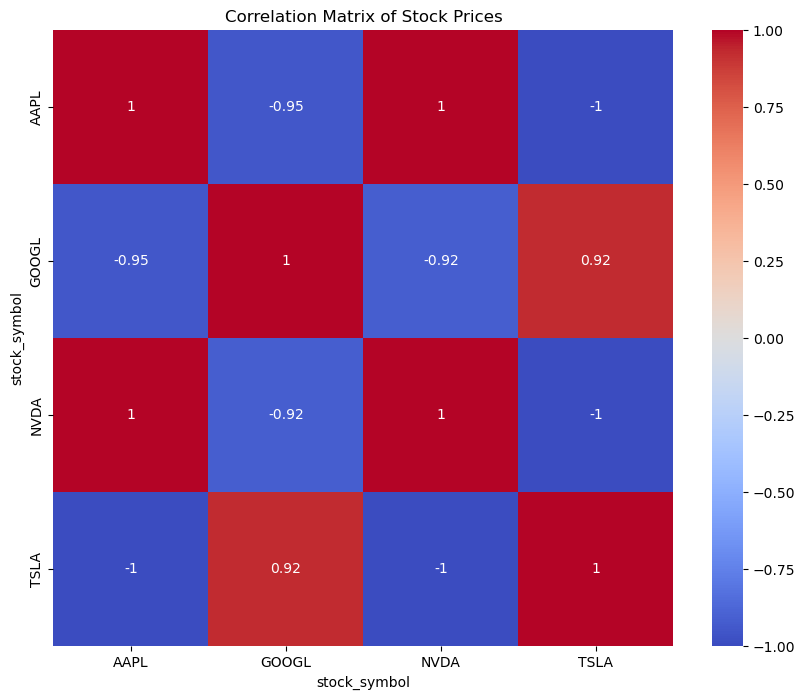

In [9]:
# Pivot data to create a matrix of prices
price_matrix = stocks.pivot(index='timestamp', columns='stock_symbol', values='price')

# Calculate correlation matrix
correlation_matrix = price_matrix.corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Stock Prices')
plt.show()


In [15]:
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id='stock-dropdown',
        options=[{'label': stock, 'value': stock} for stock in stocks['stock_symbol'].unique()],
        value=stocks['stock_symbol'].unique()[0]),
    dcc.Graph(id='price-graph')
])

@app.callback(
    Output('price-graph', 'figure'),
    [Input('stock-dropdown', 'value')]
)
def update_graph(selected_stock):
    filtered_data = stocks[stocks['stock_symbol'] == selected_stock]
    fig = px.line(filtered_data, x='timestamp', y='price', title=f'Price of {selected_stock} Over Time')
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)


In [16]:

# Convert 'timestamp' column to datetime
stocks['timestamp'] = pd.to_datetime(stocks['timestamp'])

# Calculate moving averages
stocks['20_MA'] = stocks.groupby('stock_symbol')['price'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())

# Create the Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id='stock-dropdown',
        options=[{'label': stock, 'value': stock} for stock in stocks['stock_symbol'].unique()],
        value=stocks['stock_symbol'].unique()[0]),
    dcc.Graph(id='price-graph')
])

@app.callback(
    Output('price-graph', 'figure'),
    [Input('stock-dropdown', 'value')]
)
def update_graph(selected_stock):
    stock_data = stocks[stocks['stock_symbol'] == selected_stock]
    
    # Create traces
    price_trace = go.Scatter(
        x=stock_data['timestamp'],
        y=stock_data['price'],
        mode='lines+markers',
        name='Price')
    
    ma_trace = go.Scatter(
        x=stock_data['timestamp'],
        y=stock_data['20_MA'],
        mode='lines',
        name='20-Day MA')
    
    layout = go.Layout(
        title=f'Stock Prices Over Time for {selected_stock}',
        xaxis={'title': 'Timestamp'},
        yaxis={'title': 'Price'},
        legend={'x': 0, 'y': 1},
        hovermode='closest')
    
    return {'data': [price_trace, ma_trace], 'layout': layout}

if __name__ == '__main__':
    app.run_server(debug=True)
